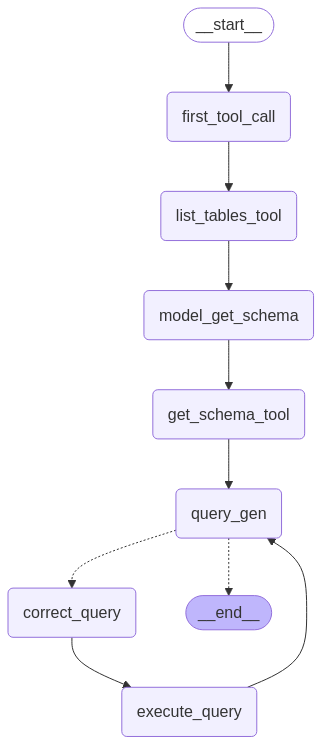

In [68]:
import warnings
warnings.filterwarnings("ignore")

from typing import Annotated, Literal, Any
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode
import boto3
import time
from langchain_community.utilities import SQLDatabase
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate

# Athena Query Execution with boto3
def run_athena_query(query: str, database: str, s3_output: str, workgroup: str = "primary") -> list:
    client = boto3.client('athena')
    response = client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database},
        ResultConfiguration={'OutputLocation': s3_output},
        WorkGroup=workgroup
    )
    query_execution_id = response['QueryExecutionId']

    # Wait for the query to complete
    while True:
        result = client.get_query_execution(QueryExecutionId=query_execution_id)
        status = result['QueryExecution']['Status']['State']
        if status in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(1)

    if status != 'SUCCEEDED':
        return [f"Error: Athena query failed with status {status}."]

    result = client.get_query_results(QueryExecutionId=query_execution_id)
    rows = result['ResultSet']['Rows']
    headers = [col['VarCharValue'] for col in rows[0]['Data']]
    output = []
    for row in rows[1:]:
        values = [col.get('VarCharValue', '') for col in row['Data']]
        output.append(dict(zip(headers, values)))
    return output

# Constants (update these accordingly)
ATHENA_DB = "athena_db"
S3_OUTPUT = "s3://athena-destination-store-cg/output/"
WORKGROUP = "primary"

# LLM Setup
llm = ChatGroq(model="llama3-70b-8192")

@tool
def query_to_database(query: str) -> str:
    """Execute a SQL query on Amazon Athena and return the result as a string."""
    result = run_athena_query(query, ATHENA_DB, S3_OUTPUT, WORKGROUP)
    return str(result)

@tool
def sql_db_list_tables() -> str:
    """Return a comma-separated list of all tables in the Athena database."""
    query = "SHOW TABLES"
    result = run_athena_query(query, ATHENA_DB, S3_OUTPUT, WORKGROUP)
    if isinstance(result, list):
        return ", ".join([list(row.values())[0] for row in result])
    return str(result)

@tool
def sql_db_schema(table_names: str) -> str:
    """Return the schema of the specified Athena table in CREATE TABLE format."""
    query = f"DESCRIBE {table_names}"
    result = run_athena_query(query, ATHENA_DB, S3_OUTPUT, WORKGROUP)
    if isinstance(result, list):
        schema_lines = [f"{row['col_name']} {row['data_type']}" for row in result if 'col_name' in row and 'data_type' in row]
        return f"CREATE TABLE {table_names} (\n    " + ",\n    ".join(schema_lines) + "\n)"
    return str(result)

llm_with_tools = llm.bind_tools([query_to_database])
llm_to_get_schema = llm.bind_tools([sql_db_schema])

class SubmitFinalAnswer(BaseModel):
    final_answer: str = Field(..., description="The final answer to the user")

    @classmethod
    def from_query_result(cls, result: list) -> "SubmitFinalAnswer":
        if not result:
            return cls(final_answer="No results found.")

        # Format result
        result_str = " ".join(str(row) for row in result)

        # Summarize using LLM
        summary_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant. Summarize the following SQL query result for a user-friendly answer."),
            ("human", "{data}")
        ])
        summarize = summary_prompt | llm
        summary_msg = summarize.invoke({"data": result_str})

        return cls(final_answer=summary_msg.content)

llm_with_final_answer = llm.bind_tools([SubmitFinalAnswer])

query_gen_system_prompt = """You are a SQL expert with a strong attention to detail. Given an input question, output a syntactically correct Athena SQL query to run, then look at the results and return the answer.

- Only call SubmitFinalAnswer for final output.
- Always limit to 5 results unless user says otherwise.
- Never use SELECT *.
- Never make DML statements.
"""
query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", query_gen_system_prompt),
    ("placeholder", "{messages}")
])
query_generator = query_gen_prompt | llm_with_tools

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def handle_tool_error(state: State):
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {"messages": [ToolMessage(content=f"Error: {repr(error)}\n please fix your mistakes.", tool_call_id=tc["id"]) for tc in tool_calls]}

def create_node_from_tool_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)], exception_key="error")

list_tables = create_node_from_tool_with_fallback([sql_db_list_tables])
get_schema = create_node_from_tool_with_fallback([sql_db_schema])
query_database = create_node_from_tool_with_fallback([query_to_database])

query_check_prompt = ChatPromptTemplate.from_messages([
    ("system", "Check the Athena SQL query for correctness."),
    ("placeholder", "{messages}")
])
check_generated_query = query_check_prompt | llm_with_tools

def first_tool_call(state: State):
    return {"messages": [AIMessage(content="", tool_calls=[{"name": "sql_db_list_tables", "args": {}, "id": "tool_123"}])]} 

def check_the_given_query(state: State):
    return {"messages": [check_generated_query.invoke({"messages": [state["messages"][-1]]})]}

def generation_query(state: State):
    message = query_generator.invoke(state)
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] == "query_to_database":
                query_str = tc["args"].get("query", "")
                if not query_str.strip().lower().startswith("select"):
                    return {"messages": [ToolMessage(content="Error: Only SELECT queries are supported.", tool_call_id=tc["id"])]}
                result = run_athena_query(query_str, ATHENA_DB, S3_OUTPUT, WORKGROUP)
                final_message = SubmitFinalAnswer.from_query_result(result)
                return {"messages": [AIMessage(content="", tool_calls=[{"name": "SubmitFinalAnswer", "args": {"final_answer": final_message.final_answer}, "id": tc["id"]}])]} 
            else:
                tool_messages.append(ToolMessage(content=f"Error: Incorrect tool called: {tc['name']}", tool_call_id=tc["id"]))
    return {"messages": [message] + tool_messages}

def should_continue(state: State):
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return END
    elif last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

def llm_get_schema(state: State):
    response = llm_to_get_schema.invoke(state["messages"])
    return {"messages": [response]}

workflow = StateGraph(State)
workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_tables_tool", list_tables)
workflow.add_node("get_schema_tool", get_schema)
workflow.add_node("model_get_schema", llm_get_schema)
workflow.add_node("query_gen", generation_query)
workflow.add_node("correct_query", check_the_given_query)
workflow.add_node("execute_query", query_database)

workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen", should_continue, {END: END, "correct_query": "correct_query"})
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

app = workflow.compile()
app

In [69]:
query={"messages": [("user", "how many orders are there in orders table?")]}
response=app.invoke(query)
response["messages"][-1].tool_calls[0]["args"]["final_answer"]

'You have a total of 5 orders.'